In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from mapclassify import NaturalBreaks

# Average Temperature Data Processing

In [2]:
# Load the Excel files
central_park_path = "../NWS_Temperature/Data/CentralPark.xlsx"
west_chester_path = "../NWS_Temperature/Data/WestChester.xlsx"

# Load the data from "Table 1" in both files
df_central_park = pd.read_excel(central_park_path, sheet_name="Table 1")
df_west_chester = pd.read_excel(west_chester_path, sheet_name="Table 1")

df_central_park = df_central_park[df_central_park['Year'] > 2001].reset_index(drop=True)

df_central_park = df_central_park.drop(['Annual'], axis=1)
df_west_chester = df_west_chester.drop(['Annual'], axis=1)

df_central_park.head(), df_west_chester.head()

(   Year   Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov  \
 0  2002  39.9  40.6  44.1  56.1  60.7  71.5  78.8  77.7  70.2  55.2  46.0   
 1  2003  27.5  30.1  43.1  49.8  58.7  68.4  75.8  76.7  67.9  55.1  50.0   
 2  2004  24.7  35.0  43.5  53.6  65.2  71.2  74.5  74.2  69.3  56.0  48.2   
 3  2005  31.3  36.5  39.5  55.1  58.9  74.0  77.5  79.7  73.3  57.9  49.6   
 4  2006  40.9  35.7  43.1  55.7  63.1  71.0  77.9  75.8  66.6  56.2  51.9   
 
     Dec  
 0  36.0  
 1  37.6  
 2  38.4  
 3  35.3  
 4  43.6  ,
    Year   Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov  \
 0  2002  35.6  36.4  40.4  51.4  56.3  67.6  74.8  73.4  65.7  51.4  41.3   
 1  2003  24.0  25.7  38.7  46.1  55.6  65.5  72.5  73.5  64.7  51.3  46.3   
 2  2004  21.2  30.9  39.6  49.9  61.3  67.2  71.3  70.6  65.5  53.3  44.6   
 3  2005  26.4  32.0  34.4  50.5  54.8  70.9  73.8  75.0  68.4  54.9  45.5   
 4  2006  36.5  31.8  39.4  51.2  59.6  69.0  75.3  72.6  63.5  53.3  48.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


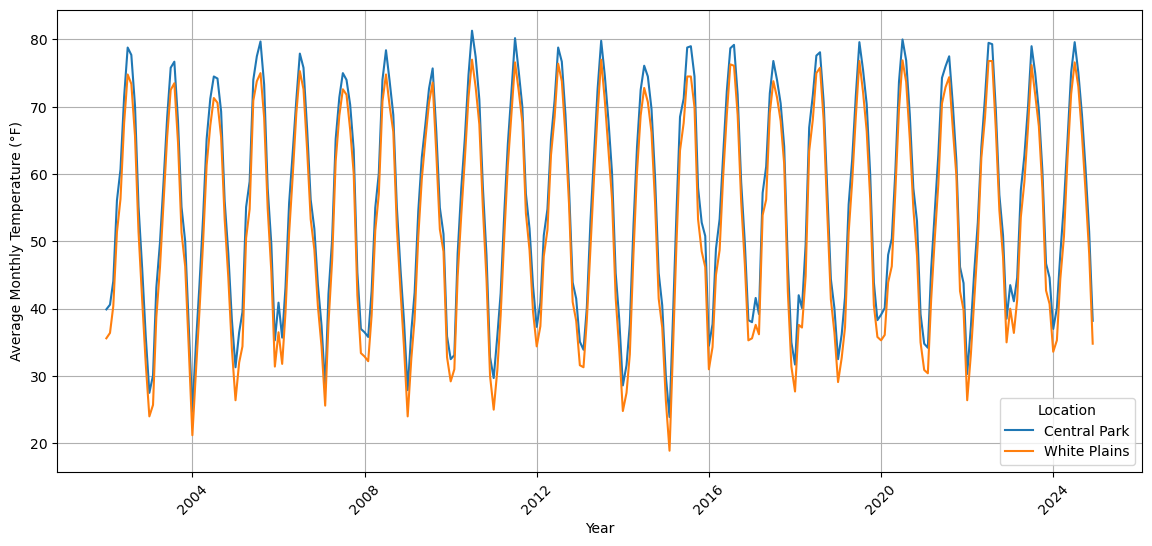

In [4]:
# Reshape the data from wide to long format
df_central_long = df_central_park.melt(id_vars=["Year"], var_name="Month", value_name="Temperature")
df_west_long = df_west_chester.melt(id_vars=["Year"], var_name="Month", value_name="Temperature")
# df_central_long.head()

# Add a column to distinguish locations
df_central_long["Location"] = "Central Park"
df_west_long["Location"] = "White Plains"

# Merge the datasets
df_combined = pd.concat([df_central_long, df_west_long])

# Convert "Month" and "Year" into a proper datetime format for plotting
month_mapping = {
    "Jan": "01", "Feb": "02", "Mar": "03", "Apr": "04", "May": "05", "Jun": "06",
    "Jul": "07", "Aug": "08", "Sep": "09", "Oct": "10", "Nov": "11", "Dec": "12"
}
df_combined["Date"] = df_combined["Year"].astype(str) + "-" + df_combined["Month"].map(month_mapping)
df_combined["Date"] = pd.to_datetime(df_combined["Date"], format="%Y-%m")

# Plot the temperature trends over time
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_combined, x="Date", y="Temperature", hue="Location")
plt.xlabel("Year")
plt.ylabel("Average Monthly Temperature (°F)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="Location")
plt.show()

In [5]:
df_res = df_combined[['Temperature','Location','Date']]
df_pivoted = df_res.pivot(index='Date', columns='Location', values='Temperature')
df_pivoted.columns.name = None
df_pivoted.reset_index(inplace=True)
df_pivoted['Date'] = df_pivoted['Date'].dt.strftime('%Y-%m')
df_pivoted.rename(columns={'Date': 'Month'}, inplace=True)
df_pivoted.rename(columns={'Central Park': 'CentralPark'}, inplace=True)
df_pivoted.rename(columns={'White Plains': 'WhitePlains'}, inplace=True)
print(df_pivoted)

       Month  CentralPark  WhitePlains
0    2002-01         39.9         35.6
1    2002-02         40.6         36.4
2    2002-03         44.1         40.4
3    2002-04         56.1         51.4
4    2002-05         60.7         56.3
..       ...          ...          ...
271  2024-08         75.1         73.0
272  2024-09         68.8         65.8
273  2024-10         60.9         57.5
274  2024-11         51.4         48.2
275  2024-12         38.2         34.8

[276 rows x 3 columns]


In [6]:
df_pivoted.to_csv('../NWS_Temperature/Avg_Temperature_Final.csv', index=False)

# UHI_Index

In [3]:
df_ind = pd.read_excel('../UHI_Index/Data/NY_Index.xlsx', dtype={'census tract number': str})
df_ind.rename(columns={"census tract number": "geoid", 
                       "urban heat island effect (temperature in degrees F)": 'temperature_F'}, inplace=True)
df_ind = df_ind[['geoid', 'temperature_F']]
# df_ind.head()
gdf_tract = gpd.read_file("../UHI_Index/Data/CensusTracts.geojson")
gdf_tract["geoid"] = gdf_tract["geoid"].astype(str)
gdf_tract = gdf_tract[['ntaname', 'boroname', 'geoid','geometry']]
gdf_tract.to_crs(2263)
gdf_tract.head()

,ntaname,boroname,geoid,geometry
0,The Battery-Governors Island-Ellis Island-Libe...,Manhattan,36061000100,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."
1,Lower East Side,Manhattan,36061001401,"MULTIPOLYGON (((-73.98837 40.71645, -73.98754 ..."
2,Lower East Side,Manhattan,36061001402,"MULTIPOLYGON (((-73.98507 40.71908, -73.98423 ..."
3,Lower East Side,Manhattan,36061001800,"MULTIPOLYGON (((-73.98985 40.72052, -73.98972 ..."
4,Lower East Side,Manhattan,36061002201,"MULTIPOLYGON (((-73.97875 40.71993, -73.97879 ..."


In [4]:
gdf_merged = gdf_tract.merge(df_ind, on="geoid", how="left")
gdf_merged = gdf_merged.dropna(subset=["temperature_F"])
gdf_merged

,ntaname,boroname,geoid,geometry,temperature_F
1,Lower East Side,Manhattan,36061001401,"MULTIPOLYGON (((-73.98837 40.71645, -73.98754 ...",9.69
2,Lower East Side,Manhattan,36061001402,"MULTIPOLYGON (((-73.98507 40.71908, -73.98423 ...",10.65
3,Lower East Side,Manhattan,36061001800,"MULTIPOLYGON (((-73.98985 40.72052, -73.98972 ...",10.65
4,Lower East Side,Manhattan,36061002201,"MULTIPOLYGON (((-73.97875 40.71993, -73.97879 ...",9.62
5,East Village,Manhattan,36061002601,"MULTIPOLYGON (((-73.97689 40.7225, -73.97728 4...",9.69
...,...,...,...,...,...
2320,Corona,Queens,36081039901,"MULTIPOLYGON (((-73.85443 40.74885, -73.85447 ...",9.96
2321,Longwood,Bronx,36005008500,"MULTIPOLYGON (((-73.89704 40.8168, -73.89621 4...",10.65
2322,Longwood,Bronx,36005008300,"MULTIPOLYGON (((-73.89845 40.81318, -73.89912 ...",10.65
2323,Hunts Point,Bronx,36005008900,"MULTIPOLYGON (((-73.89082 40.82031, -73.89089 ...",10.65


In [27]:
gdf_merged.to_file("../UHI_Index/UHI_Index.geojson", driver="GeoJSON")

[ 8.56 10.02 11.13 13.22]


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


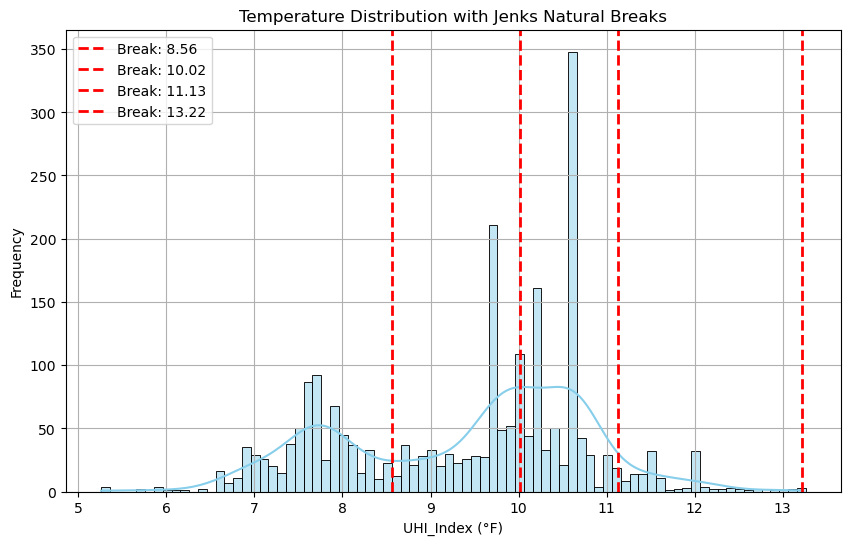

In [13]:
# Get the natural break
nb = NaturalBreaks(gdf_merged['temperature_F'], k=4)
breaks = nb.bins
print(nb.bins)

# Draw the data
plt.figure(figsize=(10, 6))
sns.histplot(gdf_merged['temperature_F'], binwidth=0.1, kde=True, color='skyblue', edgecolor='black')
for b in breaks:
    plt.axvline(x=b, color='red', linestyle='--', linewidth=2, label=f'Break: {b:.2f}')

# Set the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Final Setting
plt.title("Temperature Distribution with Jenks Natural Breaks")
plt.xlabel("UHI_Index (°F)")
plt.ylabel("Frequency")
plt.grid(True)
plt.savefig('../UHI_Index/Classification.png', dpi=300, bbox_inches='tight')
plt.show()

# plt.savefig('../UHI_Index/Classification.png', dpi=300, bbox_inches='tight')
plt.close()